# Đây là code chính từ trang web viblo để đối chiếu

/var/folders/v9/7151yn5n24j3trjjwbpjl5rr0000gn/T/ipykernel_39037/4140555782.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  src_img = imageio.imread('/Users/buidat/Documents/Code/code_for_kids/Bai_tap/img3.jpg')
/var/folders/v9/7151yn5n24j3trjjwbpjl5rr0000gn/T/ipykernel_39037/4140555782.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  tar_img = imageio.imread('/Users/buidat/Documents/Code/code_for_kids/Bai_tap/img4.jpg')


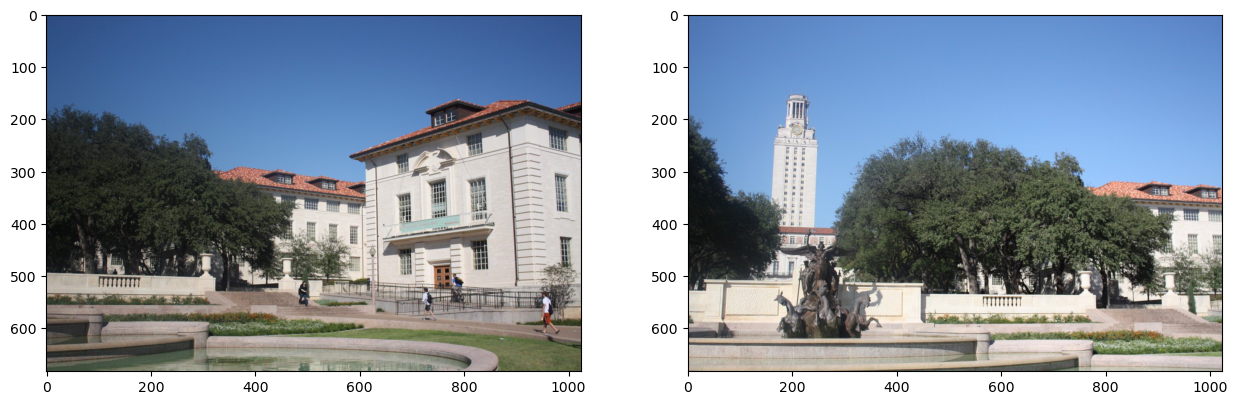

In [3]:
# do các bản opencv mới nhất không có SIFT (có bản quyền) nên ta cần downgrad openCV

import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import imageio

def plot_img(img, size=(7,7), title=""):
    cmap = "gray" if len(img.shape) == 2 else None
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=5, size=7, title=""):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        cmap="gray" if len(img.shape) == 2 else None
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


src_img = imageio.imread('/Users/buidat/Documents/Code/code_for_kids/Bai_tap/img3.jpg')
tar_img = imageio.imread('/Users/buidat/Documents/Code/code_for_kids/Bai_tap/img4.jpg')
src_gray = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
tar_gray = cv2.cvtColor(tar_img, cv2.COLOR_RGB2GRAY)
plot_imgs([src_img, tar_img], size=8)


In [17]:
SIFT_detector = cv2.SIFT_create()
kp1, des1 = SIFT_detector.detectAndCompute(src_gray, None)
kp2, des2 = SIFT_detector.detectAndCompute(tar_gray, None)

## Match keypoint
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

## Bruce Force KNN trả về list k ứng viên cho mỗi keypoint. 
rawMatches = bf.knnMatch(des1, des2, 2)
print(rawMatches[0][0].distance)

290.0706787109375


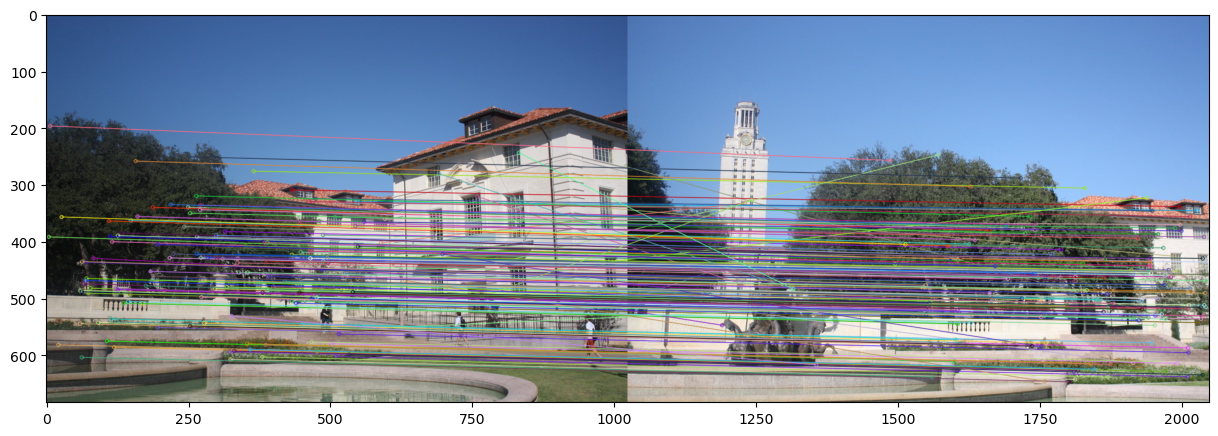

In [4]:
SIFT_detector = cv2.SIFT_create()
kp1, des1 = SIFT_detector.detectAndCompute(src_gray, None)
kp2, des2 = SIFT_detector.detectAndCompute(tar_gray, None)

## Match keypoint
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

## Bruce Force KNN trả về list k ứng viên cho mỗi keypoint. 
rawMatches = bf.knnMatch(des1, des2, 2)
matches = []
ratio = 0.75

for m,n in rawMatches:
    # giữ lại các cặp keypoint sao cho với kp1, khoảng cách giữa kp1 với ứng viên 1 nhỏ hơn nhiều so với khoảng cách giữa kp1 và ứng viên 2
    if m.distance < n.distance * 0.75:
        matches.append(m)

# do có cả nghìn match keypoint, ta chỉ lấy tầm 100 -> 200 cặp tốt nhất để tốc độ xử lí nhanh hơn
matches = sorted(matches, key=lambda x: x.distance, reverse=True)
matches = matches[:200]

img3 = cv2.drawMatches(src_img, kp1, tar_img, kp2, matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plot_img(img3, size=(15, 10))

## Nhìn vào hình dưới đây, ta thấy các cặp Keypoint giữa 2 ảnh đã được match khá chính xác, số điểm nhiễu không quá nhiều


In [6]:
kp1 = np.float32([kp.pt for kp in kp1])
kp2 = np.float32([kp.pt for kp in kp2])
pts1 = np.float32([kp1[m.queryIdx] for m in matches])
pts2 = np.float32([kp2[m.trainIdx] for m in matches])

# estimate the homography between the sets of points
(H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC)
print(H)


[[ 7.75666999e-01  3.11117215e-02  4.48405881e+02]
 [-1.31686204e-01  9.12500441e-01  7.60398057e+01]
 [-2.03218441e-04 -3.12567065e-05  1.00000000e+00]]


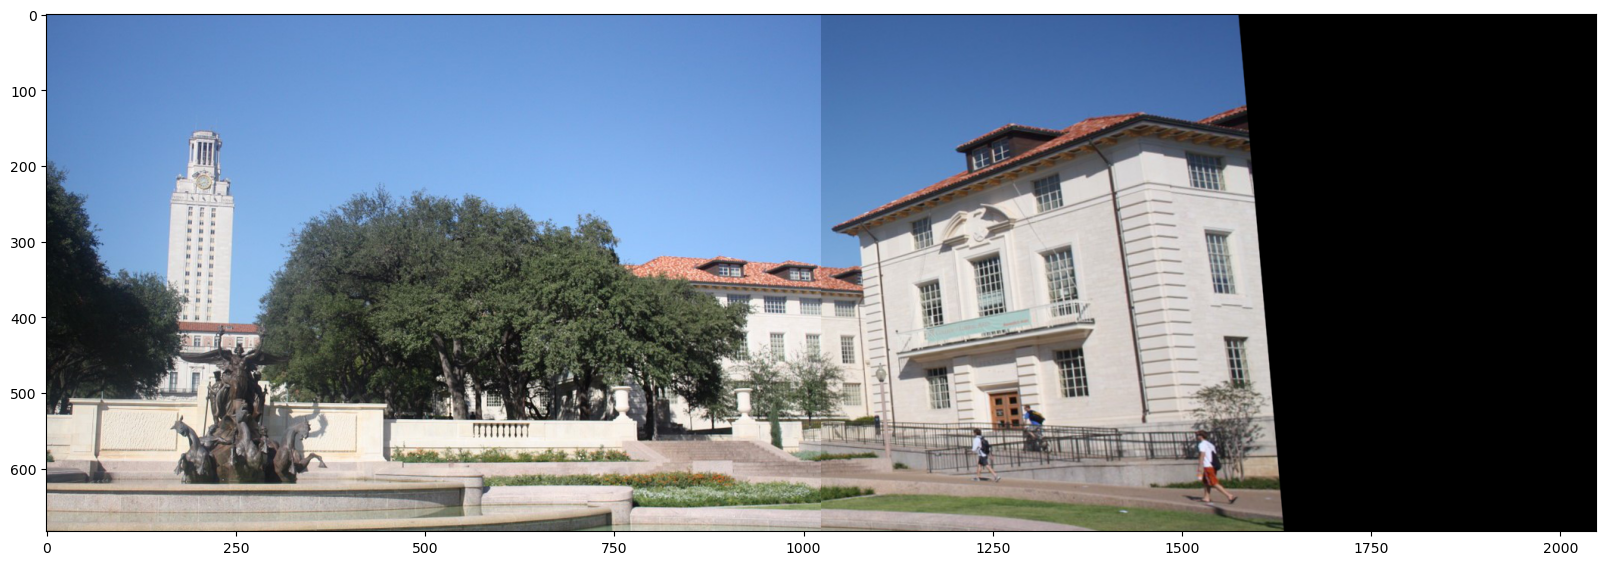

In [7]:
h1, w1 = src_img.shape[:2]
h2, w2 = tar_img.shape[:2]
result = cv2.warpPerspective(src_img, H, (w1+w2, h1))
result[0:h2, 0:w2] = tar_img
plot_img(result, size=(20,10))